# Setup

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from tqdm import tqdm
from sklearn.model_selection import KFold

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Importing Data

In [5]:
# Currently we need to manually import the csv files every session.
# Perhaps there is a better way by mounting gdrive to do that part automatically.
X_train_df = pd.read_csv("X_train.csv")
y_train_df = pd.read_csv("y_train.csv")

X_train = X_train_df.values
y_train = y_train_df.values

In [6]:
# See the data
X_train_df

,Month,Day,Weekday,Hour,Accident_Duration(min)_standardized,Distance(mi)_standardized,Temperature(F)_standardized,Humidity(%)_standardized,Pressure(in)_standardized,Visibility(mi)_standardized,...,Crossing_label-encoded,Junction_label-encoded,Station_label-encoded,Stop_label-encoded,Traffic_Signal_label-encoded,Sunrise_Sunset_label-encoded,Civil_Twilight_label-encoded,Nautical_Twilight_label-encoded,Astronomical_Twilight_label-encoded,Year_label-encoded
0,11,28,0,9,-0.874416,-0.530474,0.621184,0.320624,0.676106,0.342459,...,0,0,0,0,0,0,0,0,0,0
1,3,19,0,17,-0.872318,-0.530474,1.301672,-0.587762,0.122326,0.342459,...,1,0,0,0,1,0,0,0,0,2
2,11,30,0,0,0.111477,1.212747,-0.626377,-1.632407,-1.563094,0.342459,...,0,0,0,0,0,1,1,1,1,4
3,9,15,3,8,1.026750,1.295296,-0.002597,-0.269827,0.820571,0.342459,...,0,0,0,0,0,0,0,0,0,6
4,8,16,1,9,-0.525158,-0.530474,0.995453,0.366044,1.037268,0.342459,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237436,1,3,1,13,-1.053765,2.217892,0.394355,0.093528,-1.226010,0.342459,...,0,0,0,0,0,0,0,0,0,7
237437,7,8,3,6,-0.150029,-0.530474,0.110818,0.820237,-0.696307,-0.840973,...,0,0,0,0,0,0,0,0,0,5
237438,3,17,3,17,-0.887002,1.460392,0.280940,-0.269827,-0.816694,0.342459,...,0,0,0,0,0,0,0,0,0,6
237439,11,8,4,11,0.905086,-0.530474,0.394355,-1.632407,-0.214758,-1.629927,...,0,0,0,0,0,0,0,0,0,3


In [7]:
# See the data
y_train_df

,Severity
0,1
1,1
2,1
3,1
4,1
...,...
237436,1
237437,1
237438,1
237439,1


# Neural Network

In [24]:
# The baseline used in Moosavi et al's paper is over geospatial data with time-variant attributes,
# so the model is fundamentally different.
# Still implemented here for now as a basic model. -- Todo: use cross-validation to tune hyperparams
# Hidden layers: 512, 256, 64. ReLU hidden activation, softmax for output
# Used Batch normalization after 2nd and 3rd hidden layers and ADAM optimizer
# 0.01 initial learning rate

n_classes = len(np.unique(y_train))
n_features = X_train.shape[1]

class BaselineNetwork(nn.Module):
    @staticmethod
    def class_to_onehot(data):
        n = data.shape[0]
        n_classes = len(np.unique(data))
        o = np.zeros((n, n_classes))
        o[np.arange(n), data.flatten() - 1] = 1
        return o
    
    @staticmethod
    def onehot_to_class(data):
        o = np.argmax(data, axis=1) + 1
        return o.reshape((len(o), 1))
    
    # Casts a continuous prediction to one of the class types
    @staticmethod
    def cast_to_classes(y):
        y = torch.round(y)
        y = torch.clamp(y, min=1, max=4)  # Clamp the values between 1 and 4
        return y
    
    def __init__(self, one_hot = True):
        super().__init__()
        # self.flatten = nn.Flatten()   # No need to flatten for now since we are dealing with 1d examples
        self.layers = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64,n_classes) if one_hot else nn.Linear(64,1),
            nn.Softmax(dim=1) if one_hot else nn.ReLU(),
        )
        self.one_hot = one_hot

    def forward(self, x):
        out = self.layers(x)
        return out

    def fit(self, X_train, y_train, learning_rate = 0.01, epochs = 2000, printits = 10, X_test = None, y_test = None):
        # Dunno what they used for loss. Just putting this here for now
        if self.one_hot:
            loss_fn = nn.BCEWithLogitsLoss()
        else:
            loss_fn = nn.MSELoss()
            y_train = self.onehot_to_class(y_train)

        optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate)

        return_test_losses = False
        if X_test is not None and y_test is not None:
            print("Logging test losses enabled.")
            return_test_losses = True
        losses = []
        test_losses = []
        
        # Training cycle
        pbar = tqdm(range(epochs))
        for epoch in pbar:
            model.train()
            optimizer.zero_grad()

            out = self.forward(X_train)

            loss = loss_fn(out, y_train)
            loss.backward()

            optimizer.step()

            # Display loss. Perhaps save for later so we can generate training curve
            if epoch % printits == 0:
                pbar.set_description(f"Loss: {loss.item()}")
                
                losses.append(loss.item())
                if return_test_losses:
                    model.eval()
                    pred = self.forward(X_test)
                    loss = loss_fn(pred, y_test)
                    test_losses.append(loss.item())
            
        if return_test_losses:
            return losses, test_losses
        else:
            return losses
        
        
    def predict(self, X):
        model.eval()
        with torch.no_grad():
            output = self(X)
        if not self.one_hot:
            output = self.cast_to_classes(output)
        else:
            output = torch.argmax(output, dim=1, keepdim=True) + 1
        return output

In [9]:
class ThinnerNetwork(BaselineNetwork):
    def __init__(self, one_hot = True):
        super().__init__()
        # self.flatten = nn.Flatten()   # No need to flatten for now since we are dealing with 1d examples
        self.layers = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.ReLU(),

            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32,n_classes) if one_hot else nn.Linear(64,1),
            nn.Softmax(dim=1) if one_hot else nn.ReLU(),
        )
        self.one_hot = one_hot

In [25]:
model = BaselineNetwork(one_hot = True)

## Preparing Data

In [49]:
# Maybe move this up to importing data section
X = torch.from_numpy(X_train.astype(np.float32))

# TODO: Also try models that keep the (n,1).
# Turning y from a (n,1) array to a (n,c) array like a one-hot encoding of the classes.
y = BaselineNetwork.class_to_onehot(y_train)
y = torch.from_numpy(y.astype(np.float32))

X = X.to(device)
y = y.to(device)
model = model.to(device)

# Read in test data
# X_test_df = pd.read_csv("X_test.csv")
# y_test_df = pd.read_csv("y_test.csv")
X_test_df = pd.read_csv("X_test_resampled.csv")
y_test_df = pd.read_csv("y_test_resampled.csv")

X_test = X_test_df.values
y_test = y_test_df.values
y_test = BaselineNetwork.class_to_onehot(y_test)

X_test = torch.from_numpy(X_test.astype(np.float32)).to(device)
y_test = torch.from_numpy(y_test.astype(np.float32)).to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

## Fitting the model

In [39]:
losses, test_losses = model.fit(X, y, epochs=1000, learning_rate=1e-3, X_test = X_test, y_test = y_test)

Logging test losses enabled.


Loss: 0.6115215420722961: 100%|████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.53it/s]


In [24]:
# Alternatively, if you want to load the model instead
LOAD_PATH = "model.pt"

model.load_state_dict(torch.load(LOAD_PATH))

<All keys matched successfully>

## Saving the model parameters

In [69]:
SAVE_PATH = "model.pt"

torch.save(model.state_dict(), SAVE_PATH)

# Evaluation

In [40]:
from sklearn.metrics import precision_score,recall_score,f1_score, accuracy_score,confusion_matrix,classification_report
import seaborn as sns

In [69]:
# Taken from other notebooks
def report(y_test,y_pred, show_confusion_matrix = True):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    if show_confusion_matrix:
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)
    
def plot_learning_curve(train_losses, test_losses=None):
    """
    Plot learning curve given a list of training and optionally test losses.
    
    Args:
    train_losses (list): List of training losses.
    test_losses (list, optional): List of test losses. If not provided, only training curve will be plotted.
    """
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 6))
    
    # Plotting training curve
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    
    # Plotting test curve if provided
    if test_losses:
        plt.plot(epochs, test_losses, label='Test Loss', color='red')
    
    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [42]:
y_pred = model.predict(X_test)

Accuracy: 0.75


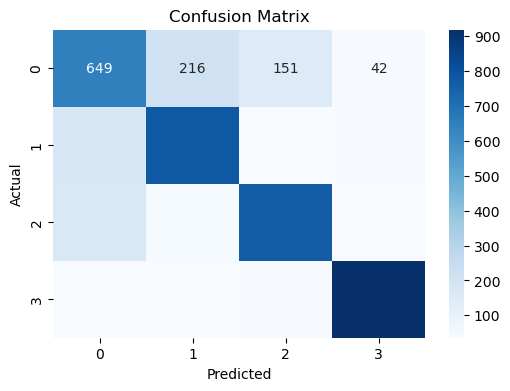

Classification Report:
              precision    recall  f1-score   support

           1       0.63      0.61      0.62      1058
           2       0.72      0.76      0.74      1031
           3       0.77      0.76      0.76      1014
           4       0.88      0.89      0.89      1035

    accuracy                           0.75      4138
   macro avg       0.75      0.75      0.75      4138
weighted avg       0.75      0.75      0.75      4138



In [43]:
report(BaselineNetwork.onehot_to_class(y_test.detach().to("cpu")), y_pred.detach().to("cpu"))

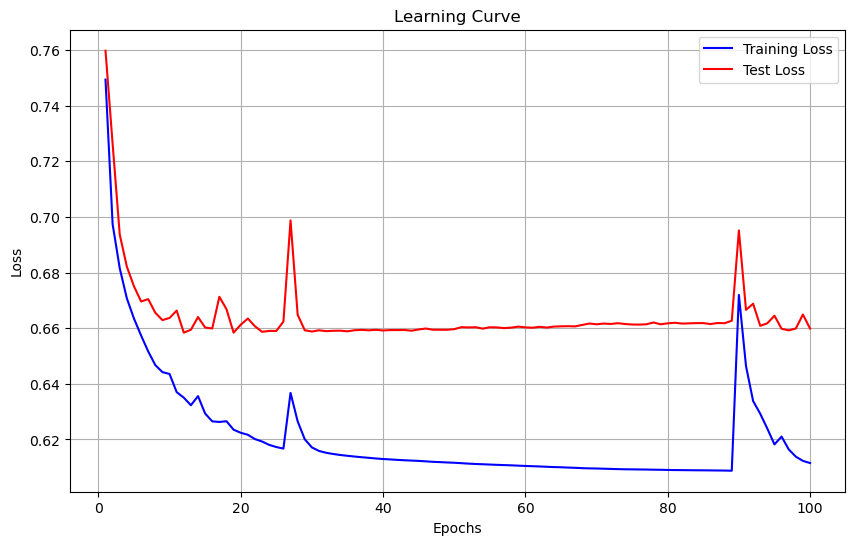

In [44]:
plot_learning_curve(losses, test_losses)

In [55]:
# Currently we need to manually import the csv files every session.
# Perhaps there is a better way by mounting gdrive to do that part automatically.
X_train_df = pd.read_csv("X_train_resampled.csv")
y_train_df = pd.read_csv("y_train_resampled.csv")

X_train = X_train_df.values
y_train = y_train_df.values

X_test_df = pd.read_csv("X_test_resampled.csv")
y_test_df = pd.read_csv("y_test_resampled.csv")

X_test = X_test_df.values
y_test = y_test_df.values

In [74]:
# Currently we need to manually import the csv files every session.
# Perhaps there is a better way by mounting gdrive to do that part automatically.
X_train_df = pd.read_csv("X_train.csv")
y_train_df = pd.read_csv("y_train.csv")

X_train = X_train_df.values
y_train = y_train_df.values

X_test_df = pd.read_csv("X_test.csv")
y_test_df = pd.read_csv("y_test.csv")

X_test = X_test_df.values
y_test = y_test_df.values

In [77]:
u, c = np.unique(y_train,return_counts=True)

In [79]:
c[1] / sum(c)

0.784590698320846

# K-Fold Cross-Validation

In [72]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=1000, lr=1e-3, do_lc = True):
    # Maybe move this up to importing data section
    X = torch.from_numpy(X_train.astype(np.float32))

    # TODO: Also try models that keep the (n,1).
    # Turning y from a (n,1) array to a (n,c) array like a one-hot encoding of the classes.
    y = BaselineNetwork.class_to_onehot(y_train)
    y = torch.from_numpy(y.astype(np.float32))
    
    y_test = BaselineNetwork.class_to_onehot(y_test)

    X_test = torch.from_numpy(X_test.astype(np.float32)).to(device)
    y_test = torch.from_numpy(y_test.astype(np.float32)).to(device)
    
    X = X.to(device)
    y = y.to(device)
    model = model.to(device)
    
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    losses, test_losses = model.fit(X, y, epochs=epochs, learning_rate=lr, X_test = X_test, y_test = y_test)
    
    y_pred = model.predict(X_test)
    
    tests = BaselineNetwork.onehot_to_class(y_test.detach().to("cpu"))
    preds = y_pred.detach().to("cpu")
    
    report(tests, preds, show_confusion_matrix = False)
    if do_lc:
        plot_learning_curve(losses, test_losses)

In [80]:
def kfold_data_split(X, y, n_splits=5, shuffle=True, random_state=None):
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    
    # Lists to store training and validation data for each fold
    X_train_folds = []
    X_val_folds = []
    y_train_folds = []
    y_val_folds = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        X_train_folds.append(X_train)
        X_val_folds.append(X_val)
        y_train_folds.append(y_train)
        y_val_folds.append(y_val)
    
    return X_train_folds, X_val_folds, y_train_folds, y_val_folds

# Example usage:
# Assuming X and y are your numpy arrays
# X shape: (n_samples, n_features)
# y shape: (n_samples,)
# X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
# y = np.array([0, 1, 0, 1, 0])

# Call the function to get the splits
X_train_folds, X_val_folds, y_train_folds, y_val_folds = kfold_data_split(X_train, y_train)

# Now you have the training and validation data for each fold
for i in range(len(X_train_folds)):
    print(f"Fold {i+1}:")
    
    X = X_train_folds[i]
    y = y_train_folds[i]
    X_val = X_val_folds[i]
    y_val = y_val_folds[i]
    
    print(f"X train shape: {X.shape}, y train shape: {y.shape}")
    print(f"X valid shape: {X_val.shape}, y valid shape: {y_val.shape}")
    
    model = BaselineNetwork()
    train_and_evaluate_model(model, X, y, X_val, y_val, epochs=1000, lr=1e-4, do_lc = False)

Fold 1:
X train shape: (189952, 33), y train shape: (189952, 1)
X valid shape: (47489, 33), y valid shape: (47489, 1)
Logging test losses enabled.


Loss: 0.6357219815254211: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.32it/s]
/home/yoberg/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoberg/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoberg/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.94      0.91     37391
           2       0.71      0.59      0.64      8953
           3       0.00      0.00      0.00       683
           4       0.00      0.00      0.00       462

    accuracy                           0.85     47489
   macro avg       0.40      0.38      0.39     47489
weighted avg       0.83      0.85      0.84     47489

Fold 2:
X train shape: (189953, 33), y train shape: (189953, 1)
X valid shape: (47488, 33), y valid shape: (47488, 1)
Logging test losses enabled.


Loss: 0.6367993950843811: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.00it/s]
/home/yoberg/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoberg/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoberg/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.92      0.91     37262
           2       0.67      0.66      0.66      9128
           3       0.00      0.00      0.00       643
           4       0.00      0.00      0.00       455

    accuracy                           0.85     47488
   macro avg       0.39      0.40      0.39     47488
weighted avg       0.83      0.85      0.84     47488

Fold 3:
X train shape: (189953, 33), y train shape: (189953, 1)
X valid shape: (47488, 33), y valid shape: (47488, 1)
Logging test losses enabled.


Loss: 0.6356105804443359: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.17it/s]
/home/yoberg/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoberg/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoberg/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.94      0.91     37351
           2       0.70      0.63      0.66      9003
           3       0.00      0.00      0.00       671
           4       0.00      0.00      0.00       463

    accuracy                           0.86     47488
   macro avg       0.40      0.39      0.39     47488
weighted avg       0.83      0.86      0.84     47488

Fold 4:
X train shape: (189953, 33), y train shape: (189953, 1)
X valid shape: (47488, 33), y valid shape: (47488, 1)
Logging test losses enabled.


Loss: 0.6356699466705322: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.14it/s]
/home/yoberg/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoberg/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoberg/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.93      0.91     37261
           2       0.69      0.63      0.66      9052
           3       0.00      0.00      0.00       678
           4       0.00      0.00      0.00       497

    accuracy                           0.85     47488
   macro avg       0.39      0.39      0.39     47488
weighted avg       0.83      0.85      0.84     47488

Fold 5:
X train shape: (189953, 33), y train shape: (189953, 1)
X valid shape: (47488, 33), y valid shape: (47488, 1)
Logging test losses enabled.


Loss: 0.6332675218582153: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 21.96it/s]


Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.94      0.91     37029
           2       0.71      0.59      0.64      9279
           3       0.00      0.00      0.00       690
           4       0.00      0.00      0.00       490

    accuracy                           0.85     47488
   macro avg       0.40      0.38      0.39     47488
weighted avg       0.82      0.85      0.83     47488



/home/yoberg/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoberg/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoberg/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,